 # Checkpoint 1: Прогнозирование конверсии пользователя в первую подписку из пробного периода
 
 **Команда**: Team № 9
 **Кейс**: № 3
 **Участники**: Горячкин Б.С., Кузьмин Т.Г., Леденев В.С. 
 
 ---
 
 ## Бизнес-контекст
 
 **Компания**: Онлайн-кинотеатр с моделью ежемесячной подписки  
 **Проблема**: Низкая конверсия из пробного периода в платную подписку, что ведет к росту расходов на привлечение новых пользователей  
 **Цель анализа**: Выявить ключевые факторы, влияющие на конверсию, и подготовить данные для построения ML-модели


## 1. Импорт библиотек и настройка среды


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline


## 2. Загрузка и первичный анализ данных

In [3]:
# Загрузка данных
df = pd.read_csv("videostreaming_platform.csv")

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Уникальных пользователй: {df['user_id'].nunique()}")

# Первые строки данных
print("Первые 5 строк данных:")
display(df.head())

# Информация о типах данных
print("\nИнформация о структуре данных:")
df.info()

Размер датасета: 28000 строк, 9 столбцов
Уникальных пользователй: 28000
Первые 5 строк данных:


,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
0,d1b6ef34-1991-452a-8c39-c83c0d5805fe,2024-02-01,St Petersburg,ios,performance,drama,2.076642,4,1
1,f1bf2396-73d8-461e-a775-9f068bd99326,2024-02-01,Other,web,seo,criminal,5.101392,1,1
2,ec9fa0be-4bd8-4fe6-910a-e9e6d4bbba28,2024-02-01,Ufa,web,performance,criminal,2.906597,1,1
3,b0195e96-af2e-4ac3-8f60-26b8d862af84,2024-02-01,Moscow,smarttv,seo,thriller,2.702388,6,0
4,a208985a-7244-4291-8d38-64c8141e27b2,2024-02-01,Ufa,web,performance,thriller,10.237305,1,1



Информация о структуре данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                28000 non-null  object 
 1   start_trial_date       28000 non-null  object 
 2   city                   27692 non-null  object 
 3   device                 28000 non-null  object 
 4   source                 28000 non-null  object 
 5   favourite_genre        20048 non-null  object 
 6   avg_min_watch_daily    28000 non-null  float64
 7   number_of_days_logged  28000 non-null  int64  
 8   churn                  28000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 1.9+ MB


### Описание признаков:
 
 | Признак | Описание | Тип данных |
 |---------|----------|------------|
 | `user_id` | Уникальный идентификатор пользователя | object |
 | `start_trial_date` | Дата начала пробного периода | object |
 | `source` | Источник привлечения (performance, seo, organic) | object |
 | `device` | Устройство регистрации (web, android, ios, smarttv) | object |
 | `city` | Город пользователя | object |
 | `favourite_genre` | Любимый жанр при регистрации | object |
 | `avg_min_watch_daily` | Среднее минут просмотра в день | float64 |
 | `number_of_days_logged` | Дней активности в пробном периоде | int64 |
 | `churn` | Конверсия в подписку (0=купил, 1=не купил) | int64 |


## 3. Анализ и обработка пропущенных значений

In [4]:
# Анализ пропусков
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
}).sort_values('Количество пропусков', ascending=False)

print("Анализ пропущенных значений:")
display(missing_df[missing_df['Количество пропусков'] > 0])

Анализ пропущенных значений:


,Количество пропусков,Процент пропусков
favourite_genre,7952,28.4
city,308,1.1


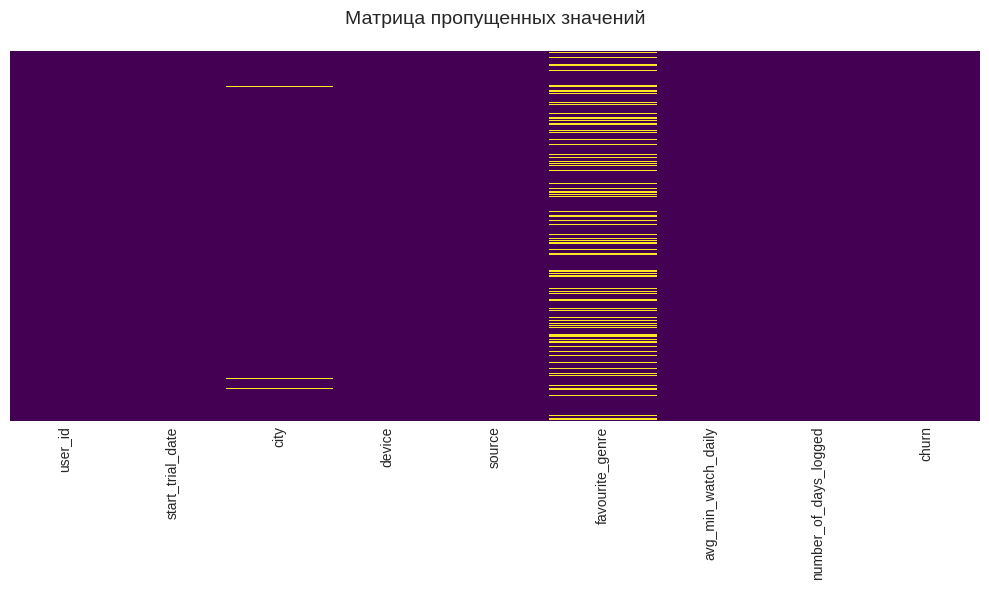

In [5]:
# Визуализация пропусков
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', 
            yticklabels=False, cbar_kws={'label': 'Пропущенные значения'})
plt.title('Матрица пропущенных значений', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 4. Очистка и предобработка данных

In [6]:
# Создаем копию для обработки
df_clean = df.copy()

In [7]:
# Обработка пропусков
# Для города - заменяем на 'Не указано'
df_clean['city'] = df_clean['city'].fillna('Не указано')
print(f"Пропуски в 'city' заменены на 'Не указано'")

# Для любимого жанра - заменяем на 'not_selected'
df_clean['favourite_genre'] = df_clean['favourite_genre'].fillna('not_selected')
print(f"Пропуски в 'favourite_genre' заменены на 'not_selected'")

Пропуски в 'city' заменены на 'Не указано'
Пропуски в 'favourite_genre' заменены на 'not_selected'


In [8]:
# Проверка уникальности
duplicate_users = df_clean.duplicated(subset=['user_id']).sum()
print(f"Проверка уникальности:")
print(f"Дубликатов user_id: {duplicate_users}")

Проверка уникальности:
Дубликатов user_id: 0


In [9]:
# Проверка аномальных значений
# Проверка числовых признаков
negative_watch_time = (df_clean['avg_min_watch_daily'] < 0).sum()
negative_days = (df_clean['number_of_days_logged'] < 0).sum()
invalid_churn = (~df_clean['churn'].isin([0, 1])).sum()

print(f"Отрицательное время просмотра: {negative_watch_time}")
print(f"Отрицательное количество дней: {negative_days}")
print(f"Некорректные значения churn: {invalid_churn}")

Отрицательное время просмотра: 0
Отрицательное количество дней: 0
Некорректные значения churn: 0


In [10]:
# Преобразование типов данных
df_clean['start_trial_date'] = pd.to_datetime(df_clean['start_trial_date'])
print(f"'start_trial_date' преобразован в datetime")

'start_trial_date' преобразован в datetime


In [11]:
# Проверка размера данных после очистки
print(
    f"Размер данных после очистки: {df_clean.shape[0]} строк,",
    f"{df_clean.shape[1]} столбцов"
)

Размер данных после очистки: 28000 строк, 9 столбцов



## 5. Статистический анализ и создание метрик для оценки конверсии
Конверсия в подписку - основной целевой показатель, с которым мы работаем.
Логично гипотезы и рассуждения строить относительно этого показателя.

In [12]:

# Описательная статистика
print("Описательная статистика числовых признаков:")
numeric_cols = ['avg_min_watch_daily', 'number_of_days_logged']
display(df_clean[numeric_cols].describe())

Описательная статистика числовых признаков:


,avg_min_watch_daily,number_of_days_logged
count,28000.000000,28000.00000
mean,7.812663,1.88600
std,7.739760,1.48293
min,0.000181,1.00000
25%,2.521966,1.00000
50%,5.419012,1.00000
75%,10.487946,2.00000
max,80.072401,7.00000


In [13]:

# Анализ конверсии
print("Создание метрик для оценки конверсии:")

# Интерпретация churn: 0 = купил подписку, 1 = не купил
conversion_distribution = df_clean['churn'].value_counts()
conversion_percentage = df_clean['churn'].value_counts(normalize=True) * 100

conversion_summary = pd.DataFrame({
    'Статус': [
        'Купил подписку (конвертировался)',
        'Не купил подписку (не конвертировался)'
    ],
    'Количество пользователей': conversion_distribution.values,
    'Процент': conversion_percentage.values
})

display(conversion_summary)

# Расчет ключевых метрик
total_users = len(df_clean)
converted_users = (df_clean['churn'] == 0).sum()
not_converted_users = (df_clean['churn'] == 1).sum()
conversion_rate = converted_users / total_users * 100
non_conversion_rate = not_converted_users / total_users * 100

print(f"Ключевые метики конверсии:")
print(f"Всего пользователей: {total_users:,}")
print(
    f"Конвертировались в подписку: {converted_users:,} ({conversion_rate:.1f}%)"
)
print(
    f"Не конвертировались: {not_converted_users:,} ({non_conversion_rate:.1f}%)"
)

Создание метрик для оценки конверсии:


,Статус,Количество пользователей,Процент
0,Купил подписку (конвертировался),22100,78.928571
1,Не купил подписку (не конвертировался),5900,21.071429


Ключевые метики конверсии:
Всего пользователей: 28,000
Конвертировались в подписку: 5,900 (21.1%)
Не конвертировались: 22,100 (78.9%)


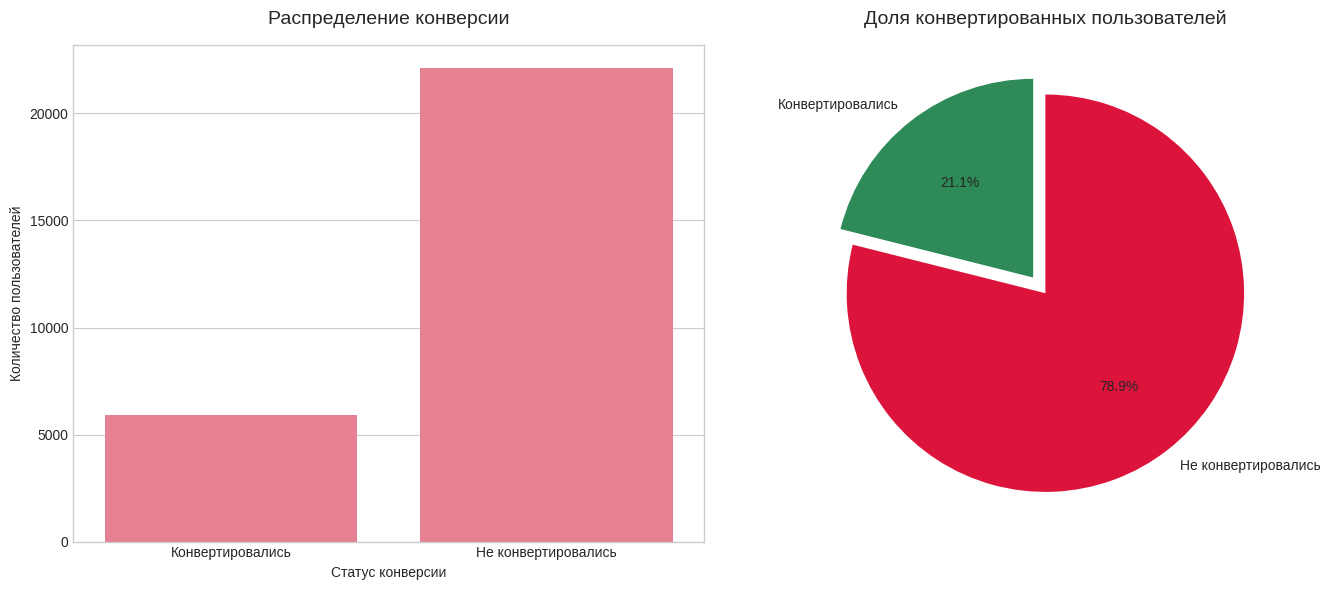

In [14]:
# Визуализация распределения конверсии
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Столбчатая диаграмма
sns.countplot(data=df_clean, x='churn', ax=axes[0])
axes[0].set_title('Распределение конверсии', fontsize=14, pad=15)
axes[0].set_xlabel('Статус конверсии')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_xticklabels(['Конвертировались', 'Не конвертировались'])

# Круговая диаграмма
colors = ['#2E8B57', '#DC143C']
labels = ['Конвертировались', 'Не конвертировались']
sizes = [conversion_rate, non_conversion_rate]

axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
           startangle=90, explode=(0.1, 0))
axes[1].set_title('Доля конвертированных пользователей', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

### Выводы по разделу 5:
 
1. **Общая конверсия составляет 21%** - каждый пятый пользователь переходит на платную подписку
2. **Значительный потенциал для роста** - 79% пользователей не конвертируются
3. **Средние показатели активности**:
    - Время просмотра: 7.8 мин/день
    - Активность: 1.9 дней

## 6. Анализ категориальных признаков


CITY - Распределение:
   Уникальных значений: 10
   Топ-5 значений:


city
Moscow           8736
St Petersburg    4480
Other            2660
Krasnodar        2575
Novosibirsk      2213
Name: count, dtype: int64

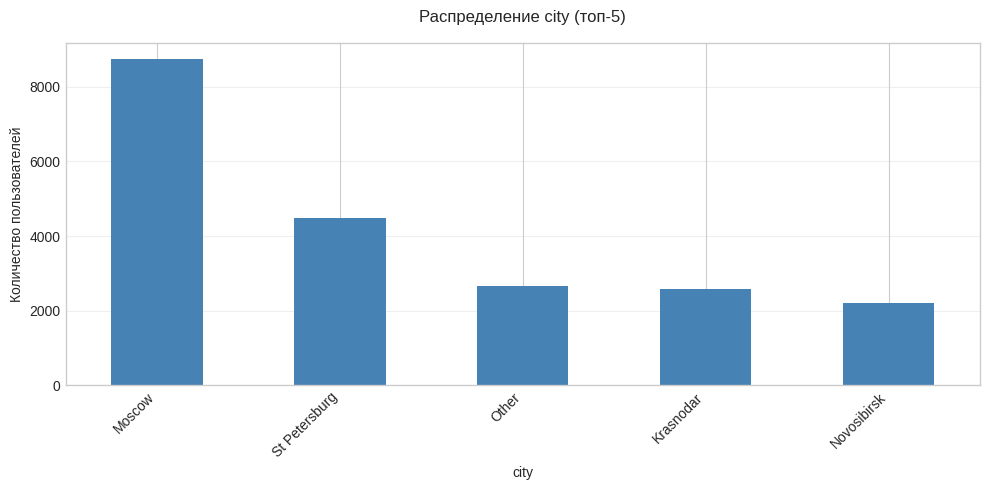


DEVICE - Распределение:
   Уникальных значений: 4
   Топ-5 значений:


device
web        17752
smarttv     3556
android     3416
ios         3276
Name: count, dtype: int64

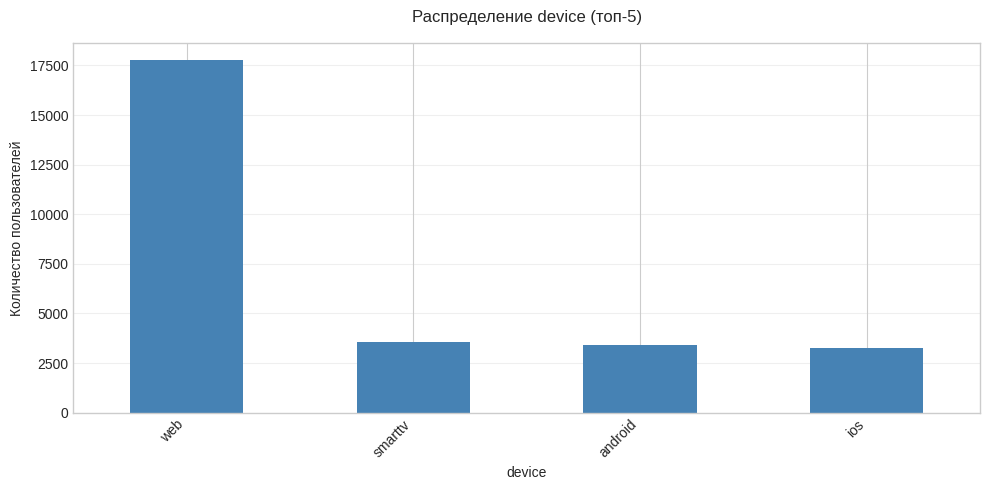


SOURCE - Распределение:
   Уникальных значений: 3
   Топ-5 значений:


source
performance    14540
organic         8204
seo             5256
Name: count, dtype: int64

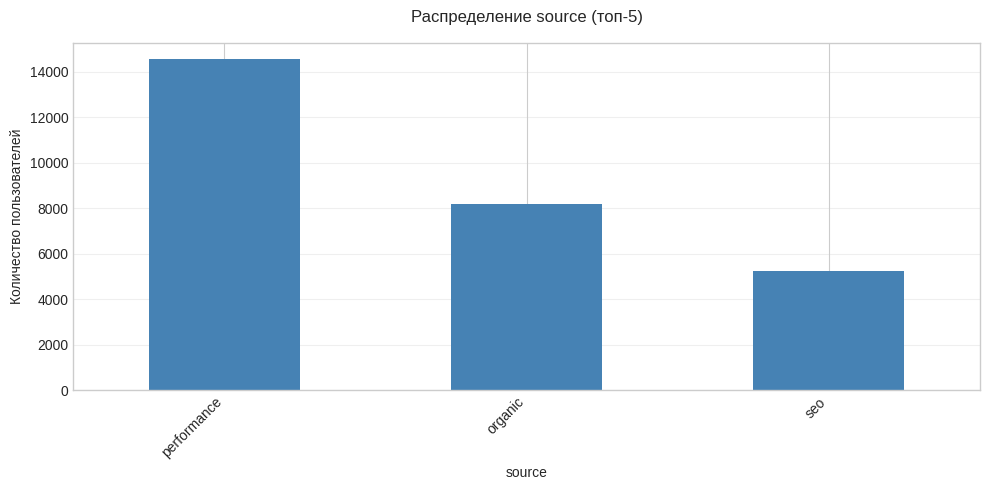


FAVOURITE_GENRE - Распределение:
   Уникальных значений: 6
   Топ-5 значений:


favourite_genre
not_selected    7952
drama           4928
comedy          4284
thriller        4172
action          3612
Name: count, dtype: int64

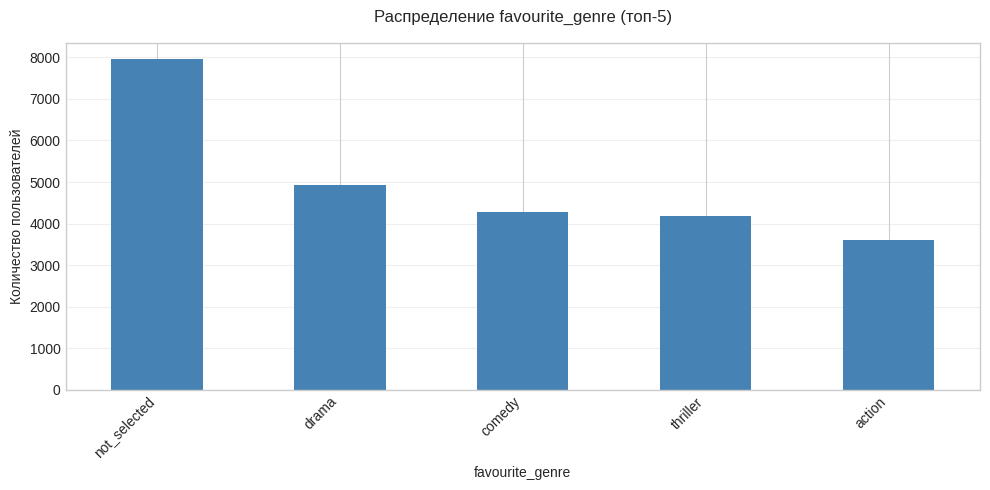

In [15]:

# Анализ нечисловых признаков
categorical_cols = ['city', 'device', 'source', 'favourite_genre']

for col in categorical_cols:
    print(f"\n{col.upper()} - Распределение:")
    value_counts = df_clean[col].value_counts()
    top_10 = value_counts.head(10)
    
    print(f"   Уникальных значений: {df_clean[col].nunique()}")
    print(f"   Топ-5 значений:")
    display(top_10.head())
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    top_10.head().plot(kind='bar', color='steelblue')
    plt.title(f'Распределение {col} (топ-5)', fontsize=12, pad=15)
    plt.xlabel(col)
    plt.ylabel('Количество пользователей')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


### Выводы по разделу 6:
 
1. **География**: Москва (47.7%) и Санкт-Петербург (20.6%) - ключевые города
2. **Устройства**: Web-версия (65.9%) доминирует, за ней Android (13.8%) и iOS (12.5%)
3. **Источники трафика**: Performance (58.4%) - основной источник, затем SEO (22.5%) и Organic (19.1%)
4. **Жанры**: Драма (18.7%) и комедия (16.7%) популярны, 27.4% пользователей не указали жанр

## 7. Создание новых аналитических признаков
Для поиска корреляционных связей логично будет ввести дополнительные признаки:
- разделить города по принципу очень курпных (Москва и СПБ) и остальных. Т.к. патерны поведения людей в двух наиболее крупных городах России могу отличаться от остальной части страны.
- дополнительны признак выбранного приоритетного жанра, поможет дальше в анализе понять, были ли проблемы на каких-то дейвайсах с выбором жанра. На ксолько осознано люди подходят к тестированию функций в пробном периоде. Влияет ли выбор жанра на удержание внимания пользователя.
- полное время, проведенное пользователем за просмотром.
- кластеризация пользователей по времени просмотра (чтобы поискать зависимости, свойственные для каждой группы)
- лкастериация пользователей по количеству активных дней (так же как в предыдущщем пункте, для поиска зависимостей, своственных для отдельной группы)

In [16]:
# Бинарные признаки
df_clean['has_genre_selected'] = (
    df_clean['favourite_genre'] != 'not_selected'
).astype(int)
df_clean['is_top_city'] = df_clean['city'].isin(
    ['Moscow', 'St Petersburg']
).astype(int)
df_clean['total_watch_time'] =(
    df_clean['avg_min_watch_daily'] * df_clean['number_of_days_logged']
)

# Категориальные признаки
df_clean['watch_time_category'] = pd.cut(
    df_clean['avg_min_watch_daily'],
    bins=[0, 2, 10, 30, float('inf')],
    labels=['<2 мин', '2-10 мин', '10-30 мин', '>30 мин']
)

df_clean['days_category'] = pd.cut(
    df_clean['number_of_days_logged'],
    bins=[0, 1, 3, 7, float('inf')],
    labels=['1 день', '2-3 дня', '4-7 дней', '8+ дней']
)

# Вывод признаков
print("Статистика по новым призакам:")
print(
    f"Пользователей с выбранным жанром: {df_clean['has_genre_selected'].sum()}",
    f"({df_clean['has_genre_selected'].mean()*100:.1f}%)"
)
print(
    f"Пользователей из Москвы/СПб: {df_clean['is_top_city'].sum()}",
    f"({df_clean['is_top_city'].mean()*100:.1f}%)"
)

print("\nРаспределение по категориям:")
print("\nВремя просмотра:")
display(df_clean['watch_time_category'].value_counts().sort_index())
print(
    f"От 2-х до 10 минут в день смотрят: {
        df_clean['watch_time_category'].value_counts()['2-10 мин'] /
        df_clean['watch_time_category'].value_counts().sum() * 100:.1f
    }% пользователей"
)

print("\nДни активности:")
display(df_clean['days_category'].value_counts().sort_index())
print(
    f"Активны только один день: {
        df_clean['days_category'].value_counts()['1 день'] /
        df_clean['days_category'].value_counts().sum() * 100:.1f
    }% пользователей"
)

Статистика по новым призакам:
Пользователей с выбранным жанром: 20048 (71.6%)
Пользователей из Москвы/СПб: 13216 (47.2%)

Распределение по категориям:

Время просмотра:


watch_time_category
<2 мин        5712
2-10 мин     14830
10-30 мин     6856
>30 мин        602
Name: count, dtype: int64

От 2-х до 10 минут в день смотрят: 53.0% пользователей

Дни активности:


days_category
1 день      17360
2-3 дня      7056
4-7 дней     3584
8+ дней         0
Name: count, dtype: int64

Активны только один день: 62.0% пользователей


### Выводы по разделу 7:
 
1. **Выбор жанра**: 71.6% пользователей указали предпочтения - хороший показатель вовлеченности
2. **География**: 47.2% пользователей из Москвы и СПб - больше половины пользователей из двух крупнейших городов
3. **Активность**: 62.0% пользователей активны только 1 день - проблема удержания
4. **Время просмотра**: 53.0% пользователей смотрят 2-10 мин/день



## 8. Анализ влияния факторов на конверсию

In [17]:
# Функция для расчета конверсии
def calculate_conversion_rate(data: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Рассчитывает конверсию в подписку по группам на основе указанного столбца.

    Функция группирует данные по указанному столбцу, вычисляет процент
    пользователей, которые конвертировались в подписку (churn == 0), и
    возвращает DataFrame с количеством пользователей и процентом конверсии 
    для каждой группы.

    Конверсия рассчитывается как доля пользователей со значением churn равным 0
    в каждой группе, умноженная на 100 для получения процента.

    Параметры
    ----------
    data : pd.DataFrame
        Входной датафрейм, содержащий данные для анализа. Должен включать
        столбец 'churn' (0 — конвертировался, 1 — не конвертировался)
        и столбец, указанный в параметре `column`.
    column : str
        Название столбца, по которому производится группировка данных.

    Возвращаемое значение
    -------------------
    pd.DataFrame
        Датафрейм с двумя колонками:
        - 'Количество пользователей' — количество пользователей в каждой группе;
        - 'Конверсия (%)' — процент конверсии в подписку для каждой группы.
        Строки отсортированы по убыванию конверсии.

    Примеры
    --------
    >>> result = calculate_conversion_rate(df, 'device')
    >>> print(result)
                Количество пользователей  Конверсия (%)
    smarttv                        120          85.0
    android                         200          78.5
    ios                            180          72.2

    Примечания
    ---------
    - Предполагается, что столбец 'churn' содержит бинарные значения: 
        0 (конвертировался)
        1 (не конвертировался)
    - Результат сортируется по колонке 'Конверсия (%)' в порядке убывания.
    - Если в данных присутствуют NaN-значения в столбце `column`, они будут
    обработаны методом groupby как отдельная группа.
    """
    conversion_rate = (
        data.groupby(column)['churn']
        .apply(lambda x: (x == 0).mean()) * 100
    )
    user_count = data.groupby(column).size()

    result = pd.DataFrame({
        'Количество пользователей': user_count,
        'Конверсия (%)': conversion_rate
    }).sort_values('Конверсия (%)', ascending=False)


    return result


DEVICE:


,Количество пользователей,Конверсия (%)
device,,
android,3416,21.370023
web,17752,21.208878
ios,3276,20.757021
smarttv,3556,20.388076


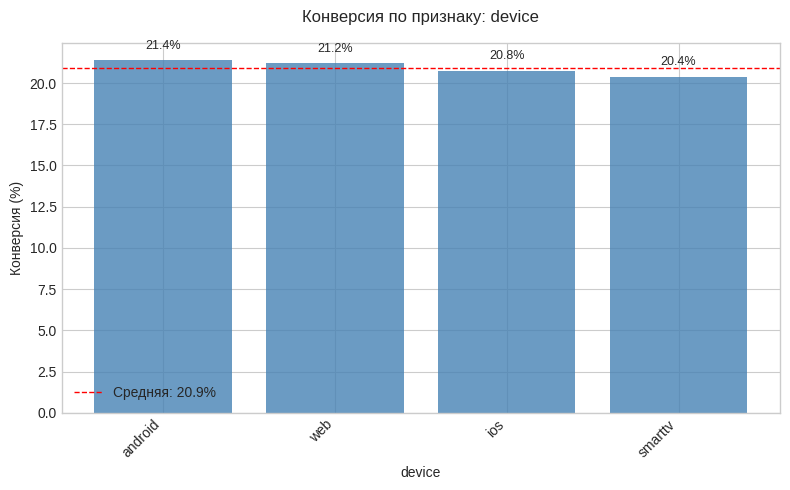


SOURCE:


,Количество пользователей,Конверсия (%)
source,,
performance,14540,21.396149
seo,5256,21.156773
organic,8204,20.441248


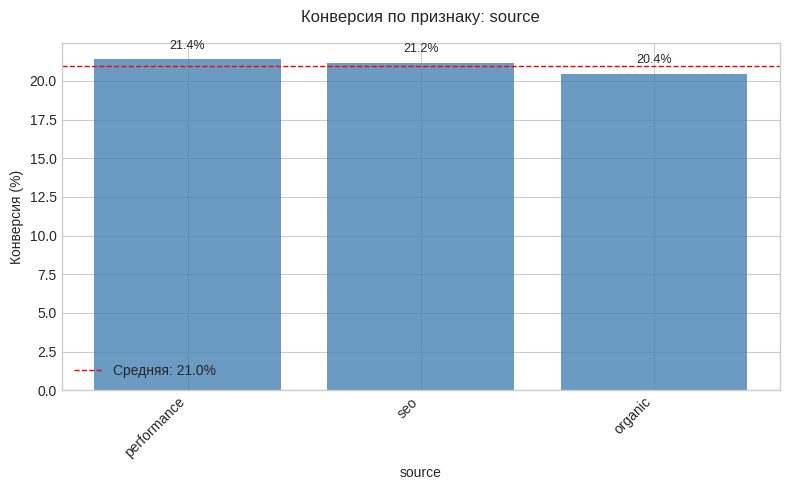


WATCH_TIME_CATEGORY:


,Количество пользователей,Конверсия (%)
watch_time_category,,
>30 мин,602,79.401993
10-30 мин,6856,46.455659
2-10 мин,14830,14.706676
<2 мин,5712,0.980392


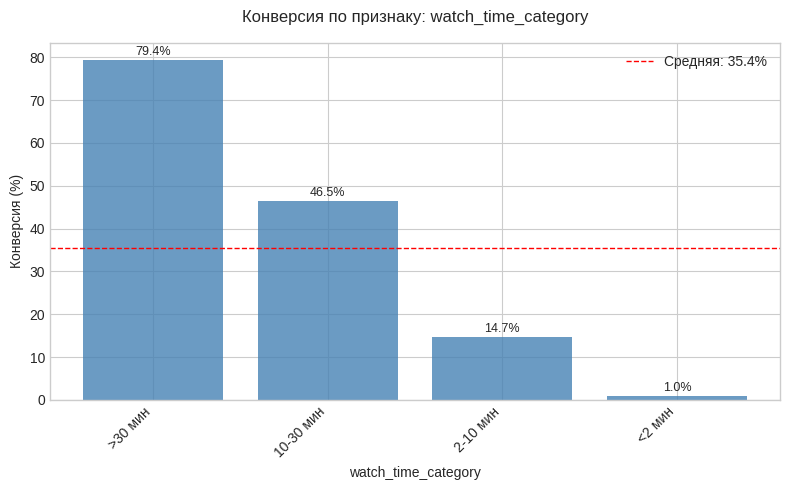


DAYS_CATEGORY:


,Количество пользователей,Конверсия (%)
days_category,,
4-7 дней,3584,22.265625
2-3 дня,7056,21.329365
1 день,17360,20.720046
8+ дней,0,NaN


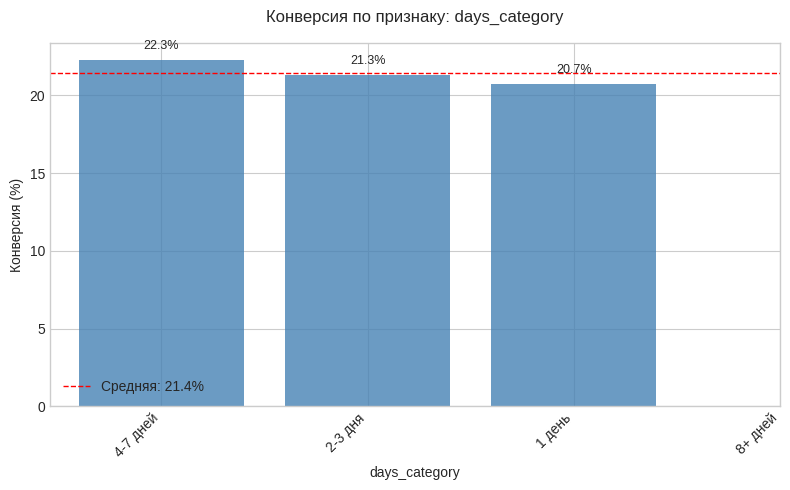


HAS_GENRE_SELECTED:


,Количество пользователей,Конверсия (%)
has_genre_selected,,
1,20048,21.099362
0,7952,21.001006


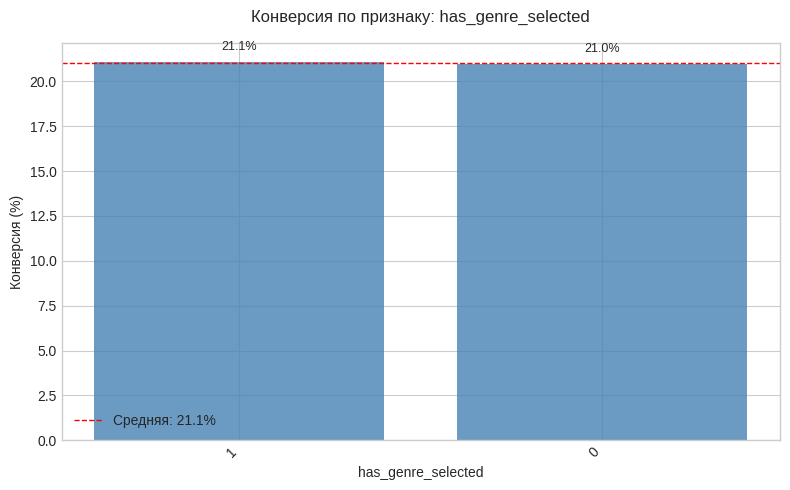


IS_TOP_CITY:


,Количество пользователей,Конверсия (%)
is_top_city,,
1,13216,21.549637
0,14784,20.643939


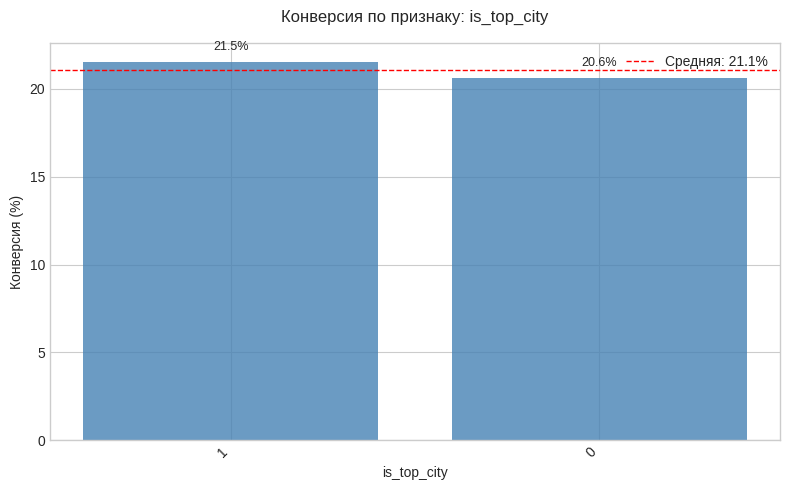

In [18]:
# Анализ по ключевым признакам
key_factors = [
    'device', 'source', 'watch_time_category', 'days_category',
    'has_genre_selected', 'is_top_city'
]

for col in key_factors:
    print(f"\n{col.upper()}:")
    stats = calculate_conversion_rate(df_clean, col)
    display(stats)
    
    # Визуализация
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        range(len(stats)), stats['Конверсия (%)'],
        color='steelblue', alpha=0.8
    )
    plt.xlabel(col)
    plt.ylabel('Конверсия (%)')
    plt.title(f'Конверсия по признаку: {col}', fontsize=12, pad=15)
    plt.xticks(range(len(stats)), stats.index, rotation=45, ha='right')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.axhline(
        y=stats['Конверсия (%)'].mean(), color='red', linestyle='--', 
        linewidth=1, label=f'Средняя: {stats["Конверсия (%)"].mean():.1f}%'
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

Корреляционный анализ:


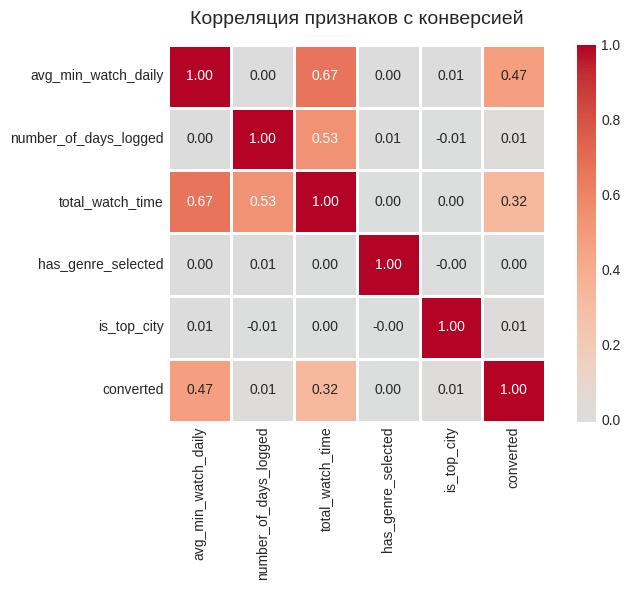


Топ корреляий с конверсией:


converted                1.000000
avg_min_watch_daily      0.472200
total_watch_time         0.324849
number_of_days_logged    0.012555
is_top_city              0.011087
has_genre_selected       0.001088
Name: converted, dtype: float64

In [19]:

# Корреляционный анализ
print("Корреляционный анализ:")

# На всяций случай, принудительно переведем в числовой тип критерии для 
# поиска корреляции
df_numeric = df_clean.copy()
df_numeric['has_genre_selected'] = df_numeric['has_genre_selected'].astype(int)
df_numeric['is_top_city'] = df_numeric['is_top_city'].astype(int)
df_numeric['converted'] = (df_numeric['churn'] == 0).astype(int)

corr_cols = ['avg_min_watch_daily', 'number_of_days_logged', 'total_watch_time',
             'has_genre_selected', 'is_top_city', 'converted']

correlation_matrix = df_numeric[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=1)
plt.title('Корреляция признаков с конверсией', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

print("\nТоп корреляий с конверсией:")
display(
    correlation_matrix['converted'].sort_values(key=abs, ascending=False).head(10)
)

### Выводы по разделу 8:
 
1. **Наибольшая разница по времени просмотра**: Категория с просмотром более 30 минут значительно отрывается вперед (конверсия: 79.4%), сильнее всего отсает категория с просмотром менее 2х минут (конверсия: 1.0%)
2. **Топ-2 фактора конверсии**:
   - Время просмотра (корреляция: 0.472)
   - Количество активных дней (корреляция: 0.325)
 
3. **Устройства**: Android лидирует (конверсия: 21,4%), SmartTV отстает (конверсия: 20,4%).
4. **Источники**: Performance-трафик эффективнее (конверсия: 21,4%) organic (конверсия: 20,4%).
5. **Города**: Конверсия из двух крупных городов (Москва, СПБ) выше (конверсия: 21.5%), в остальныых городах ниже (конверсия: 20.6%)

## 9. Сегментация пользователей
Попробуем объединить несколько признаков для анализа, чтобы получить больше групп, для фокусировки услий.

In [20]:
# Создание комбинированных сегментов: устройство | размер города
df_clean['device_is_top_city'] = (
    df_clean['device'].astype(str) + 
    ' | ' + df_clean['is_top_city'].astype(str)
)

segment_stats = df_clean.groupby('device_is_top_city').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
device_is_top_city,,
web | 1,8340,21.870504
android | 0,1774,21.533258
ios | 1,1580,21.202532



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
device_is_top_city,,
smarttv | 1,1654,20.616687
ios | 0,1696,20.341981
smarttv | 0,1902,20.189274


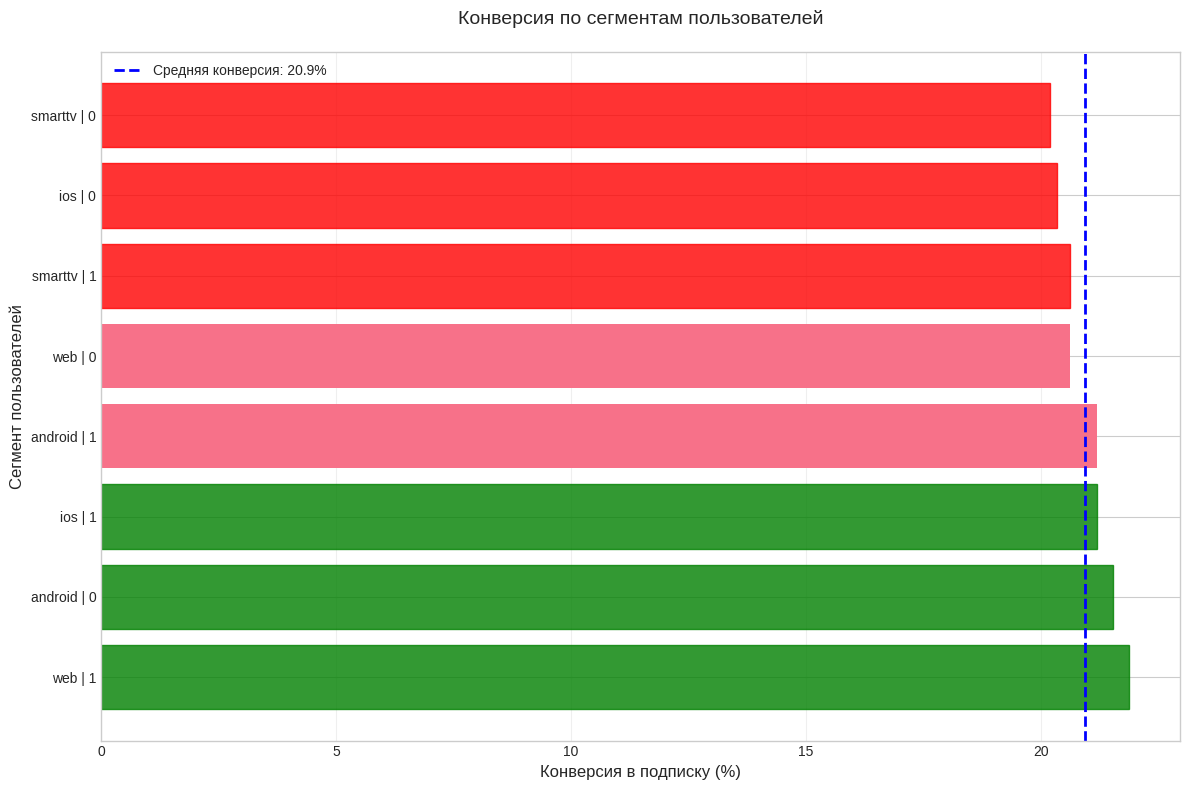

In [21]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Создание комбинированных сегментов: устройство | жанр
df_clean['device_genre'] = (
    df_clean['device'].astype(str) + 
    ' | ' + df_clean['favourite_genre'].astype(str)
)

segment_stats = df_clean.groupby('device_genre').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
device_genre,,
android | thriller,512,23.828125
android | comedy,511,23.483366
smarttv | action,516,23.449612



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
device_genre,,
android | criminal,376,18.882979
smarttv | comedy,516,16.279070
smarttv | criminal,414,15.942029


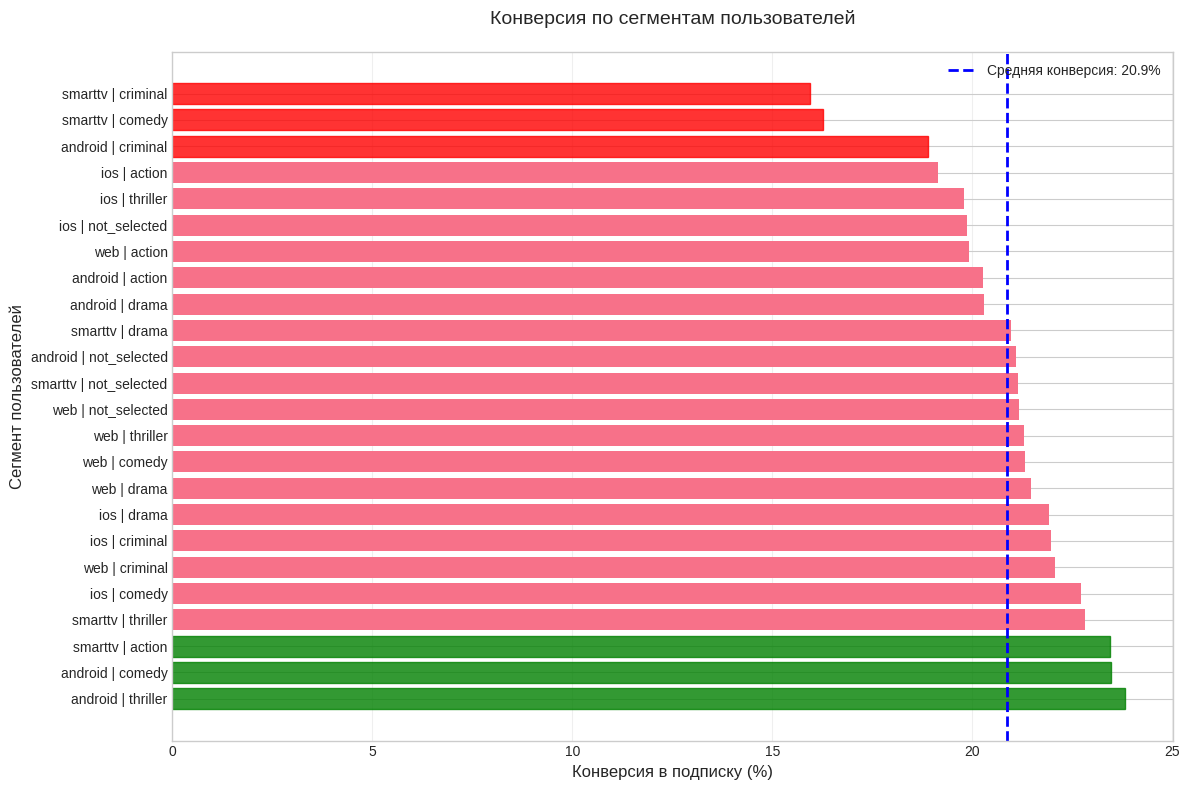

In [23]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Создание комбинированных сегментов: устройство | город
df_clean['device_city'] = (
    df_clean['device'].astype(str) + 
    ' | ' + df_clean['city'].astype(str)
)

segment_stats = df_clean.groupby('device_city').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
device_city,,
smarttv | Не указано,32,28.125000
android | Samara,215,25.116279
android | Ufa,191,24.607330



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
device_city,,
ios | Yekaterinburg,216,16.666667
android | Yekaterinburg,242,16.528926
android | Не указано,35,14.285714


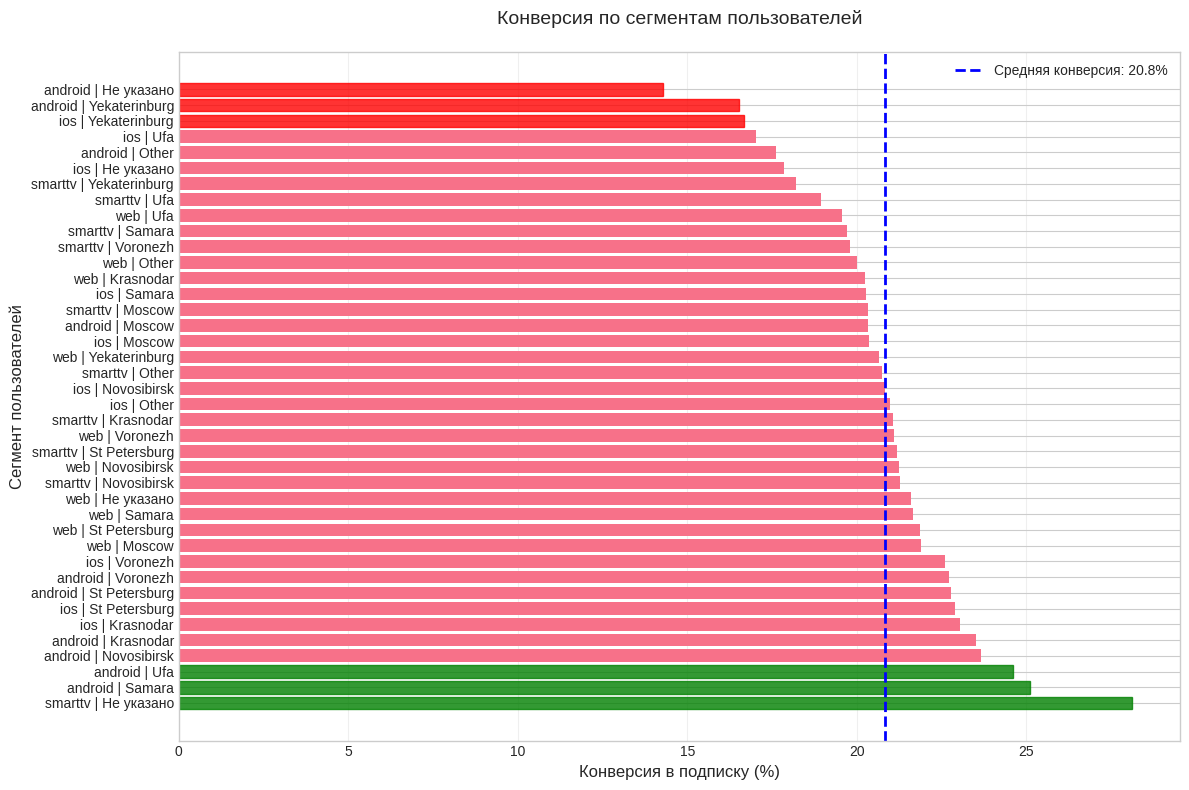

In [25]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Создание комбинированных сегментов: жанр | город
df_clean['favourite_genre_city'] = (
    df_clean['favourite_genre'].astype(str) + 
    ' | ' + df_clean['city'].astype(str)
)

segment_stats = df_clean.groupby('favourite_genre_city').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
favourite_genre_city,,
thriller | Voronezh,216,26.851852
thriller | Novosibirsk,330,23.939394
drama | Не указано,55,23.636364



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
favourite_genre_city,,
action | Novosibirsk,292,16.780822
action | Yekaterinburg,265,16.226415
action | Не указано,39,15.384615


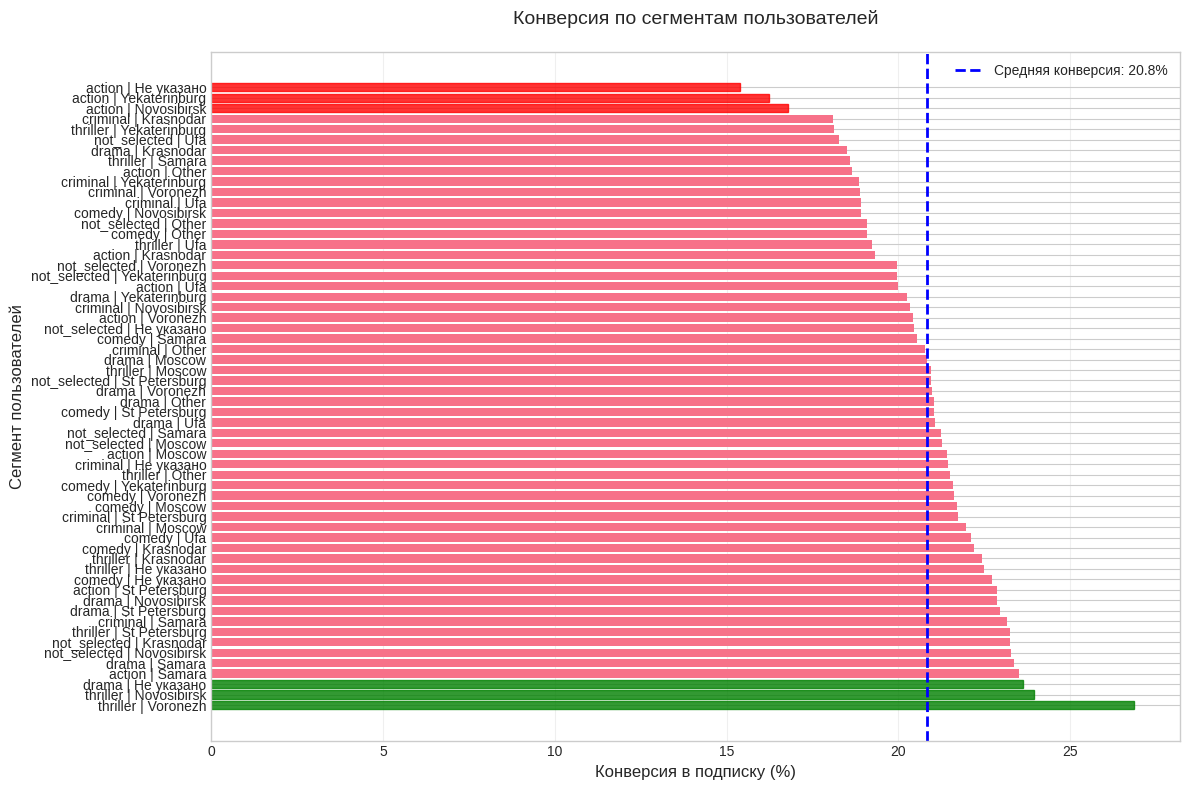

In [27]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Создание комбинированных сегментов: жанр | время просмотра
df_clean['favourite_genre_watch_time_category'] = (
    df_clean['favourite_genre'].astype(str) + 
    ' | ' + df_clean['watch_time_category'].astype(str)
)

segment_stats = df_clean.groupby('favourite_genre_watch_time_category').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
favourite_genre_watch_time_category,,
action | >30 мин,60,85.000000
comedy | >30 мин,92,82.608696
not_selected | >30 мин,177,81.355932



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
favourite_genre_watch_time_category,,
criminal | <2 мин,633,0.947867
not_selected | <2 мин,1617,0.803958
comedy | <2 мин,861,0.348432


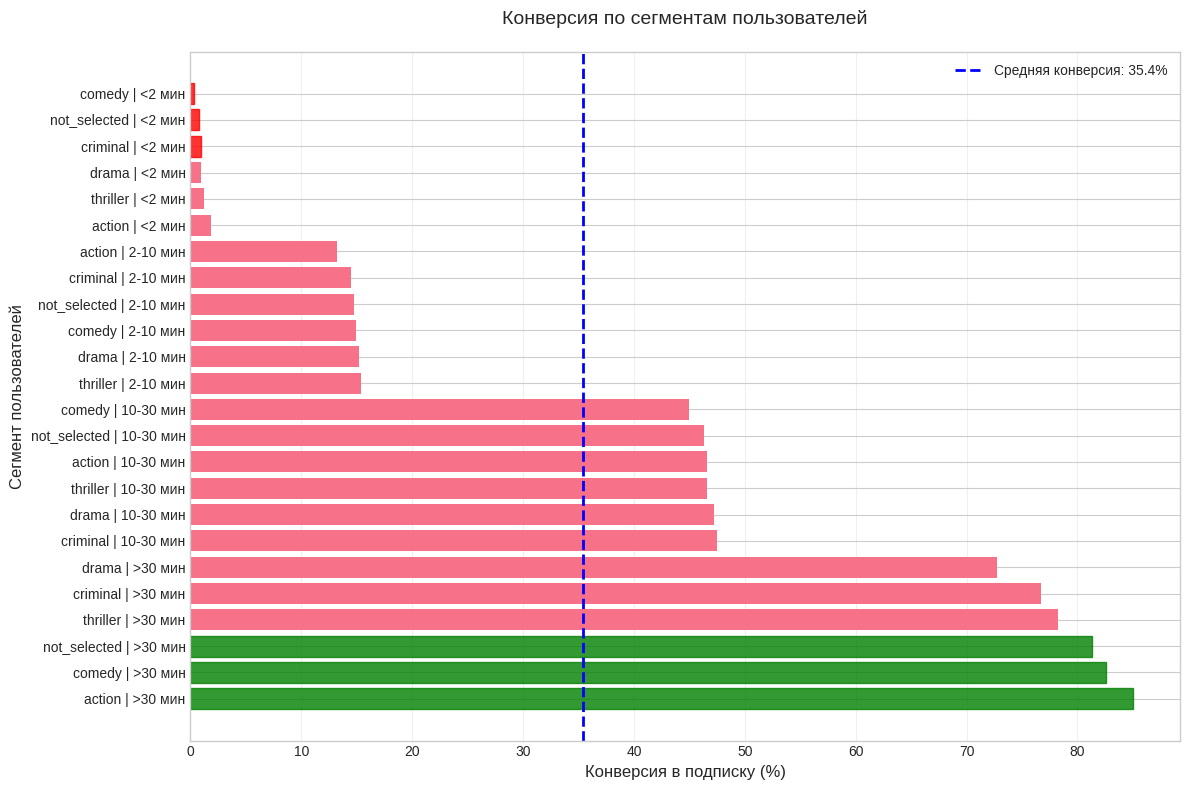

In [29]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Создание комбинированных сегментов: устройство | время просмотра
df_clean['device_watch_time_category'] = (
    df_clean['device'].astype(str) + 
    ' | ' + df_clean['watch_time_category'].astype(str)
)

segment_stats = df_clean.groupby('device_watch_time_category').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
device_watch_time_category,,
android | >30 мин,79,86.075949
ios | >30 мин,72,81.944444
smarttv | >30 мин,69,79.710145



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
device_watch_time_category,,
ios | <2 мин,661,0.907716
android | <2 мин,707,0.848656
smarttv | <2 мин,749,0.801068


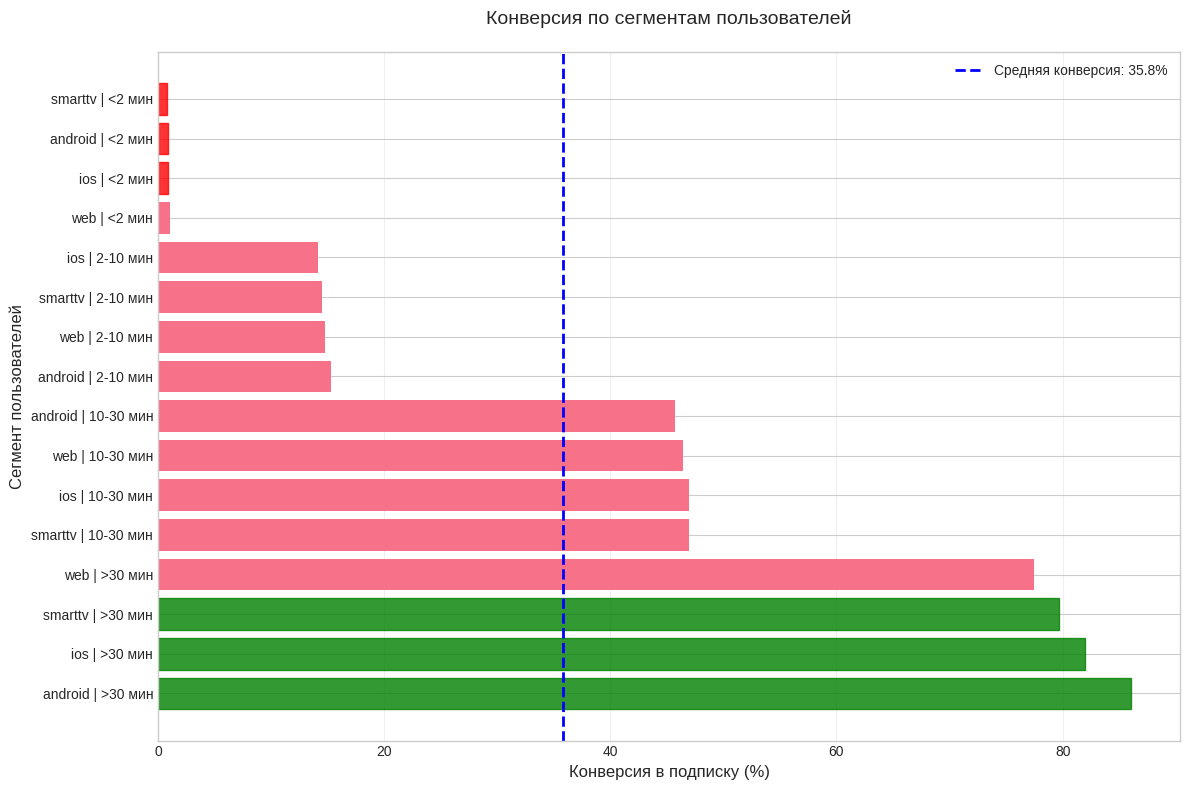

In [31]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# Создание комбинированных сегментов: устройство | количество активных дней
df_clean['device_days_category'] = (
    df_clean['device'].astype(str) + 
    ' | ' + df_clean['days_category'].astype(str)
)

segment_stats = df_clean.groupby('device_days_category').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
device_days_category,,
android | 4-7 дней,438,26.027397
ios | 4-7 дней,427,23.653396
web | 4-7 дней,2271,21.884632



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
device_days_category,,
android | 1 день,2128,20.394737
ios | 2-3 дня,831,19.855596
smarttv | 4-7 дней,448,19.196429


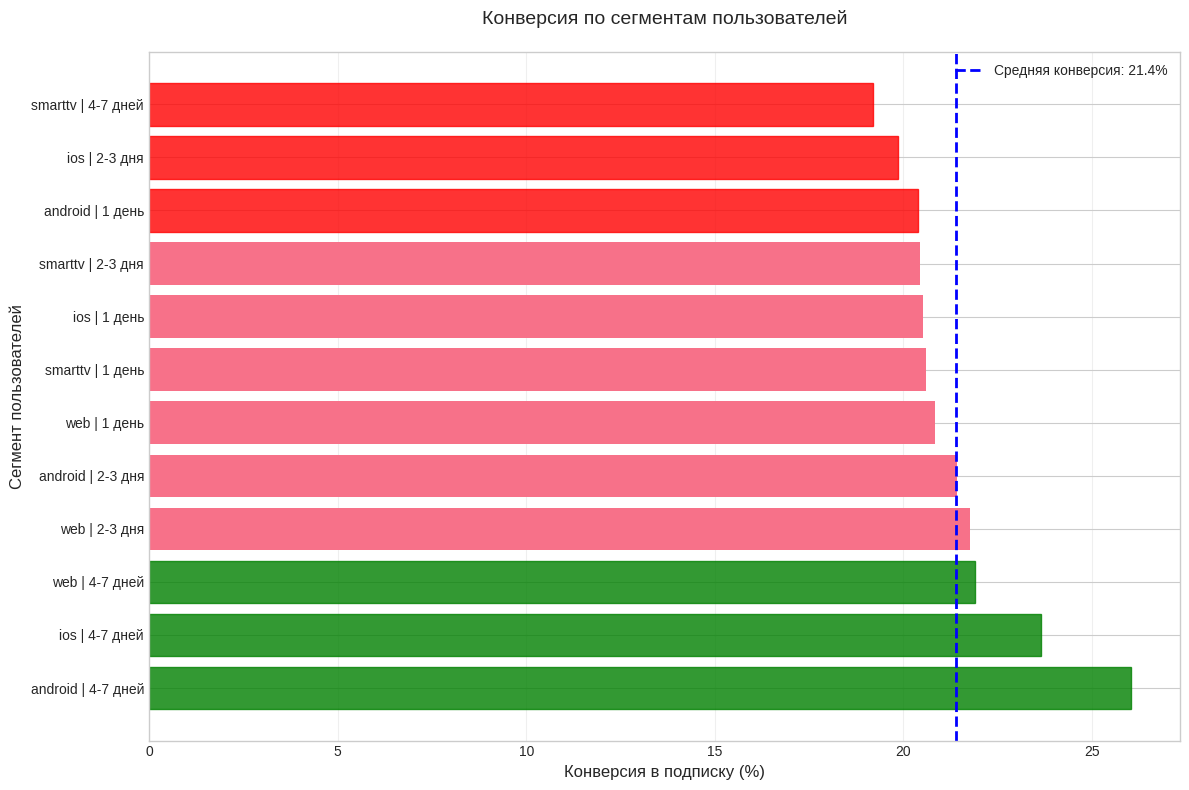

In [33]:
# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Создание комбинированных сегментов время просмотра | количество активных дней
df_clean['user_segment'] = (
    df_clean['watch_time_category'].astype(str) + 
    ' | ' + df_clean['days_category'].astype(str)
)

segment_stats = df_clean.groupby('user_segment').agg({
    'user_id': 'count',
    'churn': lambda x: (x == 0).mean() * 100
}).rename(columns={'user_id': 'Количество', 'churn': 'Конверсия (%)'})

segment_stats = segment_stats.sort_values('Конверсия (%)', ascending=False)

print("Сегментация пользователей:")

print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))

Сегментация пользователей:

Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
user_segment,,
>30 мин | 4-7 дней,76,88.157895
>30 мин | 1 день,362,79.005525
>30 мин | 2-3 дня,164,76.219512



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
user_segment,,
<2 мин | 4-7 дней,731,1.231190
<2 мин | 1 день,3555,1.012658
<2 мин | 2-3 дня,1426,0.771388


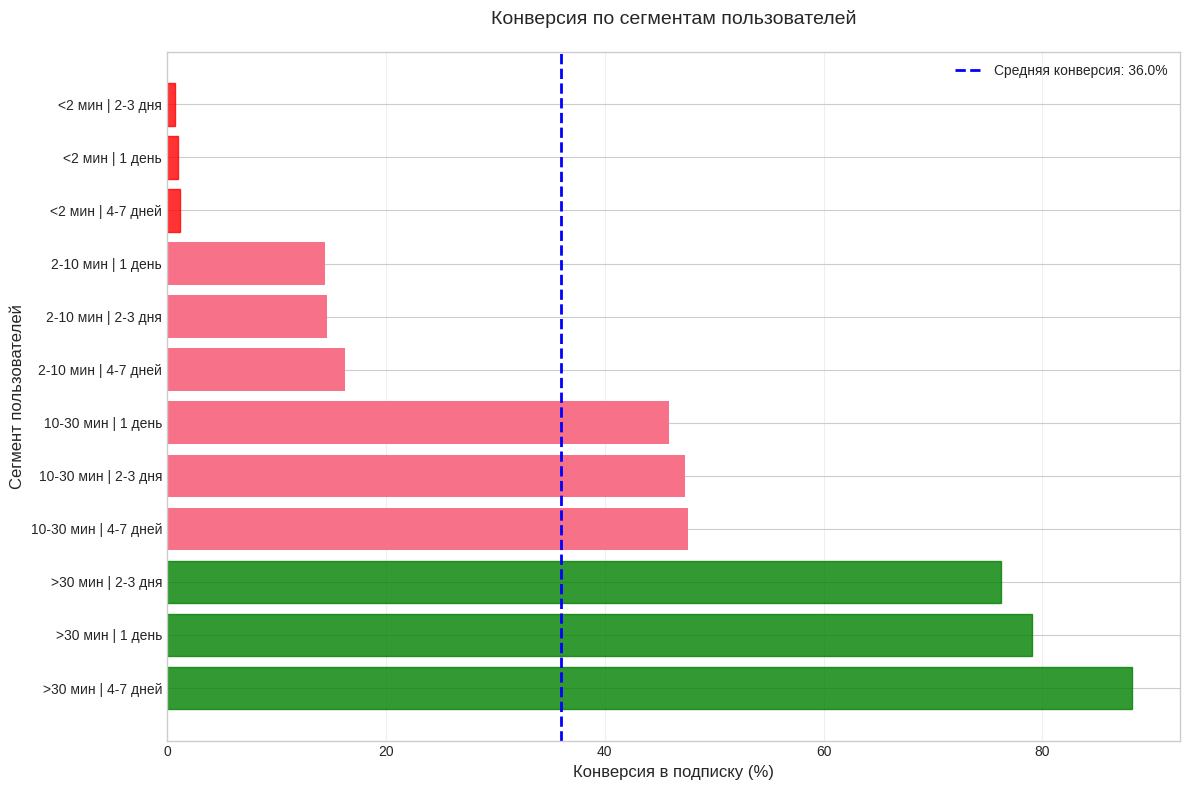

Разница между худшим и лучшим 87.4
Над какой аудиторией можно работать: 20618


In [35]:

# Визуализация
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(segment_stats)), segment_stats['Конверсия (%)'])
plt.yticks(range(len(segment_stats)), segment_stats.index)
plt.xlabel('Конверсия в подписку (%)', fontsize=12)
plt.ylabel('Сегмент пользователей', fontsize=12)
plt.title('Конверсия по сегментам пользователей', fontsize=14, pad=20)

# Цветовая дифференциация
for i, bar in enumerate(bars):
    if i < 3:  # Топ-3 с высокой конверсией
        bar.set_color('green')
        bar.set_alpha(0.8)
    elif i >= len(bars) - 3:  # Топ-3 с низкой конверсией
        bar.set_color('red')
        bar.set_alpha(0.8)

plt.axvline(
    x=segment_stats['Конверсия (%)'].mean(),
    color='blue',
    linestyle='--', 
    linewidth=2,
    label=f'Средняя конверсия: {segment_stats["Конверсия (%)"].mean():.1f}%'
)
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
print(
    f"Разница между худшим и лучшим {
        segment_stats.iloc[0]['Конверсия (%)'] -
        segment_stats.iloc[-1]['Конверсия (%)']:.1f
    }"
)
print(
    f"Над какой аудиторией можно работать: {
        segment_stats.tail(3)['Количество'].sum() +
        segment_stats.tail(4)['Количество'].sum()
    }"
)

### Выводы по разделу 9:
 
1. **Лучшие сегменты**: Пользователи с >30 мин просмотра и 4-7 дней активности (конверсия: 88.16%)
2. **Худшие сегменты**: Пользователи с <2 мин просмотра и 1-2 дня активности (конверсия: 0.77%)
3. **Разница в конверсии** между лучшим и худшим сегментом: 87.4 п.п.
4. **Приоритет для вмешательства**: 20 618 пользователей в низкоконвертирующих сегментах (мнее 10 мин. просмотра)


## 10. Формулирование гипотез для исследования:


**H1**: Персонализированные рекомендации для "средних" пользователей увеличат конверсию на 8-12%
  - *Основание*: Пользователи с менее 10 мин просмотра составляют 73.6% аудитории
  - *Метод проверки*: Система рекомендаций на основе просмотров

In [36]:
print(
    f"Пользователи с просмотрами 1-2 мин: {
        (segment_stats.tail(3)['Количество'].sum() +
         segment_stats.tail(4)['Количество'].sum()) /
        segment_stats['Количество'].sum() * 100:.1f
    }"
)

Пользователи с просмотрами 1-2 мин: 73.6


 **H2**: Улучшение интерфейса/привлекательности для SmartTV увеличит конверсию на 15-20%
   - *Основание*: SmartTV-пользователи имеют самую низкую конверсию (20.4 %), по сравнению с Android-пользователями (21.4%)
   - *Метод проверки*: A/B тест с улучшенным UX для SmartTV-версии


In [37]:
print(
    f"Конверсия SmartTV-пользователей {
        calculate_conversion_rate(
            df_clean, 'device'
        ).loc['smarttv', 'Конверсия (%)']:.1f
    }"
)

Конверсия SmartTV-пользователей 20.4



**H3**: Время просмотра - самый сильный предиктор конверсии
  - *Основание*: Корреляция 0.472
  - *Метод проверки*: Проверка в ML-модели наиболее значимых признаков


In [38]:
print(
    f"Корреляция конверсии от времени просмотра: {
        correlation_matrix.loc['avg_min_watch_daily', 'converted']:.3f
    }"
)

Корреляция конверсии от времени просмотра: 0.472


**H4**: Комбинация времени просмотра × количество активных дней улучшит прогнозную мощность модели
  - *Основание*: watch_time_category + days_category показывают лучшие результаты разделения конверсии
  - *Метод проверки*: Создание искуственных признаков взаимодействия

In [39]:
print("\nТоп-3 сегмента по конверсии:")
display(segment_stats.head(3))

print("\nТоп-3 Сегмента с низкой конверсий:")
display(segment_stats.tail(3))


Топ-3 сегмента по конверсии:


,Количество,Конверсия (%)
user_segment,,
>30 мин | 4-7 дней,76,88.157895
>30 мин | 1 день,362,79.005525
>30 мин | 2-3 дня,164,76.219512



Топ-3 Сегмента с низкой конверсий:


,Количество,Конверсия (%)
user_segment,,
<2 мин | 4-7 дней,731,1.231190
<2 мин | 1 день,3555,1.012658
<2 мин | 2-3 дня,1426,0.771388
